In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import tensorflow_probability as tfp
tfd = tfp.distributions
tfkl = tf.keras.layers

### Mutual Information Estimation

The following notebook is adapted from [a Google Research's notebook](https://github.com/google-research/google-research/blob/master/vbmi/vbmi_demo.ipynb) by Ben Poole, Sherjil Ozair, A&auml;ron van den Oord, Alexander A. Alemi, George Tucker (see the corresponding paper [here](https://arxiv.org/abs/1905.06922)). Our goal is to build efficient estimators of mutual information (MI) that leverage neural networks. Mutual information is given by:

$$I(X; Y) = \mathbb{E}_{p(x,y)}\left[\log \frac{p(x,y)}{p(x)p(y)}\right].$$
    
Estimating MI is challenging as we often only have access to samples $x, y$ but do not know the densities. To overcome these challenges, we review and presented several variational estimators of MI. These estimators replace the intractable MI objective with a tractable objective that lower or upper bounds MI, and depends on neural-network-powered critics and baselines.

### Implementation

* For most bounds, we will work with a matrix, denoted by `f` or `scores` that contains the output of the critic for every pair of elements in the minibatch: `scores[i, j] = critic(x[j], y[i])`
* Most variational lower bounds on MI require samples from both the joint $p(x, y)$ and marginal distributions $p(x)p(y)$. For a minibatch of size $K$, we have $K$ samples from the joint $p(x,y)$ and can form samples from the marginal by using all pairs $x_i, y_j$ where $i \ne j$, giving $K \times (K -1)$ samples from the marginal. The diagonal elements of the `scores` matrix correspond to the $K$ critic scores for samples from the joint, and the off-diagonal elements correspond to the critic scores for samples from the marginal.
* In this notebook we assume that we use all other elements in the minibatch as negative samples. For certain InfoMax tasks, for example when negatives come from the same image but at other spatial locations, one has to be more careful about summing over and selecting the right positive and negative examples to form the two expectations.
* Separable critics are the more efficient and popular architecture. Instead of having to do $K^2$ forward passes, you only have to do $2 \times K$ followed by an inner product. 


### Barber & Agakov (BA) Lower Bound

The Barber & Agakov (2003) variational lower bound on mutual information can be found by approximating the conditional distribution $p(x \mid y)$ by a tractable parametric distribution $q(x \mid y)$:

$$I(X; Y) = \mathbb{E}_{p(x, y)} \left[ \frac{p(x \mid y)}{p(x)} \right] = \mathbb{E}_{p(x, y)} \left[ \frac{q(x \mid y)}{p(x)} \right] + \mathbb{E}_{p(y)} \left[\text{KL}(p(x \mid y) \, || \, q(x \mid y)) \right] \geq \mathbb{E}_{p(x, y)} \left[ \frac{q(x \mid y)}{p(x)} \right] \triangleq I_{\text{BA}}.$$

Since it's hard to estimate the entropy term of $I_{\text{BA}}$, i.e. $-\mathbb{E}_{p(x, y)}[\log p(x)]$, we can parametrize th density ratio $q(x \mid y) / p(x)$ by an unnormalized model using a critic $f(x, y)$:

$$I_{\text{BA}} = \mathbb{E}_{p(x, y)}[f(x, y)] - \mathbb{E}_{p(y)}[\log(Z(y)] \;\; \text{where} \;\; \frac{q(x \mid y)}{p(x)} = \frac{1}{Z(y)} e^{f(x, y)} \;\; \text{and} \;\; Z(y) = \mathbb{E}_{p(x)}[e^{f(x, y)}].$$

### Donsker & Varadhan (DV) Lower Bound

Note that $\mathbb{E}_{p(y)}[\log(Z(y)] \neq \mathbb{E}_{p(x)p(y)}[f(x, y)]$ since the logarithmic operation sits between the two expectations. However, we can proceed in two different ways from here. The first way is to apply Jensen inequality to bring the two expectations together, i.e. $\mathbb{E}_{p(y)}[\log(Z(y)] \leq \log \left(\mathbb{E}_{p(y)}(Z(y))\right) = \log \left(\mathbb{E}_{p(x)p(y)}[e^{f(x, y)}]\right)$. The resulting lower bound is credited to Donsker & Varadhan (1983):

$$I_{\text{DV}} \triangleq \mathbb{E}_{p(x, y)}[f(x, y)]  -  \log\left(\mathbb{E}_{p(x)p(y)}[e^{f(x, y)}]\right).$$

The Donsker & Varadhan has been used in the MINE paper (Belghazi et al., 2018). However, naive Monte-Carlo approximations of the second term yields biased estimates since the expected value of an exponential function is dominated by infrequent large values.

### TUBA & NWJ Lower Bound

The second approach from the Barber & Agakov is to get rid of the logarithmic by using $\log(Z(y)) \geq Z(y) / a(y) + \log(a(y)) - 1$ for some function $a(y)$ of our choice. The resulting variational lower bound on mutual information is given by:

$$I_\text{TUBA} \triangleq 1 + \mathbb{E}_{p(x, y)} \left[\log {e^{ f(x,y)}\over{ a(y)}} \right] - \mathbb{E}_{p(x)p(y)} \left[  \frac{e^{{ f(x , y)}}}{ a(y)}\right].$$

Letting $a(y)$ be the constant $e$ recovers the bound of Nguyen, Waintright, and Jordan (2010) as in the variational derivations of $f$-divergence:

$$I_{\text{NWJ}} \triangleq \mathbb{E}_{p(x, y)}[f(x, y)] - \mathbb{E}_{p(x)p(y)}\left[e^{f(x, y)- 1} \right].$$

These bounds can be low bias, but are typically high variance. To implement these bound, we need the critic scores for all elements in the minibatch: `scores[i, j] = critic(x[i], y[j])`, and the value of the baseline `a[j] = baseline(y[j])` for every `y`. Instead of requiring the baseline to be non-negative, we assume that the argument passed in is $\log a(y)$, and will exponentiate it to get the baseline $a(y)$. The implementation also requires averaging the exponentiated critic over all independent samples, corresponding to the off-diagonal terms in `scores`,  which is done by the `reduce_logmeanexp_nodiag` function.

In [ ]:
def reduce_logmeanexp_nodiag(x, axis=None):
    batch_size = x.shape[0]
    x = x - tf.linalg.tensor_diag(np.inf * tf.ones(batch_size))
    logsumexp = tf.reduce_logsumexp(x, axis=axis)
    num_elem = batch_size - 1 if axis else batch_size * (batch_size - 1.)
    return logsumexp - tf.math.log(num_elem)


def tuba_lower_bound(scores, log_baseline=None):
    if log_baseline is not None:
        scores -= log_baseline[:, None]
    joint_term = tf.reduce_mean(tf.linalg.diag_part(scores))
    marg_term = tf.exp(reduce_logmeanexp_nodiag(scores))
    return 1. + joint_term - marg_term


def nwj_lower_bound(scores):
    return tuba_lower_bound(scores - 1.)

### InfoNCE Lower Bound
In contrast to previous bounds, the InfoNCE variational lower bound is derived by comparing samples within a batch. It typically has low variance but high bias:

$$I_{\text{NCE}} \triangleq \mathbb{E}_{p^K(x,y)}\left[\frac{1}{K} \sum_{i=1}^K \log \frac{e^{f(x_i, y_i)}}{\frac{1}{K}\sum_{j=1}^K e^{f(x_j, y_i)}}\right].$$

The expectation $p^K(x,y)$ draws $K$ samples from the joint $(x, y)$. So for a minibatch of $K$ examples, we are effectively forming a single sample Monte-Carlo estimate of the quantity inside the expectation. Here we use `reduce_logsumexp` so the implementation matches the math, but you can also implement this with `sparse_softmax_cross_entropy_with_logits` using a different label for each of the `K` elements in the minibatch.

In [ ]:
def infonce_lower_bound(scores):
    """InfoNCE lower bound from van den Oord et al. (2018)."""
    nll = tf.reduce_mean(tf.linalg.diag_part(scores) - tf.reduce_logsumexp(scores, axis=1))
    # Alternatively, we can calculate negative log likelihood using cross entropy loss
    # nll = -tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=scores, labels=tf.range(batch_size)))
    return tf.math.log(tf.cast(scores.shape[0], tf.float32)) + nll

### Interpolated Lower Bounds

The interpolated lower bounds are the trickiest to implement, but also provide the best of both worlds: lower bias or variance relative to the NWJ and InfoNCE bounds. We start with the multisample TUBA bound from the paper:

$$I(X_1; Y) \geq 1+\mathbb{E}_{p(x_{1:K})p(y|x_1)}\left[\log \frac{e^{f(x_1,y)}}{a(y; x_{1:K})}\right] - \mathbb{E}_{p(x_{1:K})p(y)}\left[ \frac{e^{f(x_1,y)}}{a(y; x_{1:K})}\right]$$

Coding up this bound is tricky as we need $K+1$ samples from the joint $p(x,y)$: $K$ of these samples are used for the first term, and the additional sample is used for the independent sample from $p(y)$ for the second term. In the minibatch setting, we can implement this by holding out the $j$th sample from the joint,  and using $y_j$ for the indepent sample from $p(y)$ for the second term, and $x_\ne j$ (all elements in the minibatch except element $j$) for the samples from $p(x_{1:K})$. A single-sample Monte-Carlo approximation to the NWJ bound is then given by:

$$1 + \log \frac{e^{f(x_1, y_1)}}{a(y_1; x_{\ne j}, \alpha)} - \frac{e^{f(x_1, y_j)}}{a(y_j; x_{\ne j}, \alpha)}$$

Instead of just using $(x_1, y_1)$ as the only positive example, we can use all samples from the joint in the minibatch: $(x_i, y_i)$. Summing over the $K$ elements which are not the element we are holding out for the second expectation ($y_j$), yields:

$$1 + \frac{1}{K}\sum_{i\ne j} \left(\log \frac{e^{f(x_i, y_i)}}{a(y_i; x_{\ne j}, \alpha)} - \frac{e^{f(x_i, y_j)}}{a(y_j; x_{\ne j}, \alpha)}\right)$$

Furthermore, in the minibatch setting we can choose any element in the minibatch to hold out for the second expectation. Summing over all possible (leave one out) combinations yields:

$$1 + \frac{1}{K+1} \sum_{j=1}^{K+1} \frac{1}{K}\sum_{i\ne j} \left(\log \frac{e^{f(x_i, y_i)}}{a(y_i; x_{\ne j}, \alpha)} - \frac{e^{f(x_i, y_j)}}{a(y_j; x_{\ne j}, \alpha)}\right)$$

where the interpolated baseline is given by $a(y; x_{1:M}) = \alpha \frac{1}{K} \sum_{l=1}^K e^{f(x_l, y)} + (1-\alpha) q(y)$. We work in log-space for numerical stability, using `compute_log_loomean` to compute the leave one out InfoNCE baselines, and `log_interpolate` to compute the log baseline for the interpolated bound.m

In [5]:
def log_interpolate(log_a, log_b, alpha_logit):
    """Numerically stable implementation of log(alpha * a + (1-alpha) * b)."""
    log_alpha = -tf.nn.softplus(-alpha_logit)
    log_1_minus_alpha = -tf.nn.softplus(alpha_logit)
    y = tf.reduce_logsumexp(tf.stack((log_alpha + log_a, log_1_minus_alpha + log_b)), axis=0)
    return y


def compute_log_loomean(scores):
    """Compute the log leave-one-out mean of the exponentiated scores.

    For each column j we compute the log-sum-exp over the row holding out column j.
    This is a numerically stable version of:
    log_loosum = scores + tfp.math.softplus_inverse(tf.reduce_logsumexp(scores, axis=1, keepdims=True) - scores) 
    Implementation based on tfp.vi.csiszar_divergence.csiszar_vimco_helper.
    """
    max_scores = tf.reduce_max(scores, axis=1, keepdims=True)
    lse_minus_max = tf.reduce_logsumexp(scores - max_scores, axis=1, keepdims=True)
    d = lse_minus_max + (max_scores - scores)
    d_ok = tf.not_equal(d, 0.)
    safe_d = tf.where(d_ok, d, tf.ones_like(d))
    loo_lse = scores + tfd.softplus_inverse(safe_d)
    # Normalize to get the leave one out log mean exp
    loo_lme = loo_lse - tf.math.log(scores.shape[1] - 1.)
    return loo_lme


def interpolated_lower_bound(scores, baseline, alpha_logit):
    """Interpolated lower bound on mutual information.

    Interpolates between the InfoNCE baseline ( alpha_logit -> -infty),
    and the single-sample TUBA baseline (alpha_logit -> infty)

    Args:
    scores: [batch_size, batch_size] critic scores
    baseline: [batch_size] log baseline scores
    alpha_logit: logit for the mixture probability

    Returns:
    scalar, lower bound on MI
    """
    batch_size = scores.shape[0]
    # Compute InfoNCE baseline
    nce_baseline = compute_log_loomean(scores)
    # Inerpolated baseline interpolates the InfoNCE baseline with a learned baseline
    interpolated_baseline = log_interpolate(
      nce_baseline, tf.tile(baseline[:, None], (1, batch_size)), alpha_logit)
    # Marginal term.
    critic_marg = scores - tf.linalg.diag_part(interpolated_baseline)[:, None]
    marg_term = tf.exp(reduce_logmeanexp_nodiag(critic_marg))

    # Joint term.
    critic_joint = tf.linalg.diag_part(scores)[:, None] - interpolated_baseline
    joint_term = (tf.reduce_sum(critic_joint) - tf.reduce_sum(tf.linalg.diag_part(critic_joint))) / (batch_size * (batch_size - 1.))
    return 1 + joint_term  - marg_term

### JS-KL Hybrid Lower Bound
We can also use different approaches for training the critic vs. estimating mutual informaiton. The $I_\text{JS}$ bound just trains the critic with the standard lower bound on the Jensen-Shannon divergence used in GANs, and then evaluates the critic using the $I_\text{NWJ}$ lower bound on KL (mutual information). 

We use a fun trick to simplify the code here `z = x + tf.stop_gradient(y - x)` where `z` gives the value of `y` on the forward pass, but the gradient of `x` on the backward pass.

In [ ]:
def js_lower_bound(f):
    n = tf.cast(f.shape[0], tf.float32)
    f_diag = tf.linalg.tensor_diag_part(f)
    first_term = tf.reduce_mean(-tf.nn.softplus(-f_diag))
    second_term = (tf.reduce_sum(tf.nn.softplus(f)) - tf.reduce_sum(tf.nn.softplus(f_diag))) / (n * (n - 1.))
    js = first_term - second_term
    mi = nwj_lower_bound(f)
    return js + tf.stop_gradient(mi - js)

### Network Architectures

**Critics**: we consider two choices of neural network architectures for $f(x,y)$. Using a separable baseline is typically more efficient, as you only have to do `batch_size` forward passes through each network vs. the `batch_size * batch_size` with the concat critic.

1. **Separable**: $f(x,y) = g(x)^Th(y)$ where $g$ and $h$ are two different MLPs
2. **Concat**: $f(x,y) = g([x, y])$ where we concatenate $x$ and $y$ and feed them into a single MLP

**Baselines**: we consider three possibilities for the baseline $a(y)$:
1. **Constant**: $a(y)$ is a fixed constant (as in $I_\text{NWJ}$)
2. **Unnormalized**: $a(y)$ is a neural network that produces a scalar output (representing $\log a(y)$)
3. **Gaussian**: $a(y)$ is a Gaussian distribution. Here we fix the mean and variance to be 1, but you could use any tractable density with learnable parameters as well.

In [ ]:
def mlp(hidden_dim, output_dim, layers, activation):
    return tf.keras.Sequential([tfkl.Dense(hidden_dim, activation) for _ in range(layers)] + [tfkl.Dense(output_dim)])


class SeparableCritic(tf.keras.Model):
    def __init__(self, hidden_dim, embed_dim, layers, activation, **extra_kwargs):
        super().__init__()
        self.net1 = mlp(hidden_dim, embed_dim, layers, activation)
        self.net2 = mlp(hidden_dim, embed_dim, layers, activation)

    def call(self, x, y):
        scores = tf.matmul(self.net1(x), self.net2(y), transpose_b=True)
        return scores


class ConcatCritic(tf.keras.Model):
    def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
        super().__init__()
        self.net = mlp(hidden_dim, 1, layers, activation)

    def call(self, x, y):
        batch_size = tf.shape(x)[0]
        x_tiled = tf.tile(x[None, :], (batch_size, 1, 1))
        y_tiled = tf.tile(y[:, None], (1, batch_size, 1))
        xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size, batch_size, -1])
        scores = self.net(xy_pairs)
        return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))


class ConditionalGaussian(tf.keras.Model):
    def __init__(self, rho, **extra_kwargs):
        super().__init__()
        self.rho = rho

    def call(self, x, y):
        cond_dist = tfd.MultivariateNormalDiag(x * self.rho, scale_identity_multiplier=tf.sqrt(1.0 - tf.square(rho)))
        return cond_dist.log_prob(y[:, None, :])


CRITICS = {
    "separable": SeparableCritic,
    "concat": ConcatCritic,
    "conditional": ConditionalGaussian,
}

BASELINES = {
    "constant": lambda: None,
    "unnormalized": lambda: mlp(hidden_dim=512, output_dim=1, layers=2, activation="relu"),
    "gaussian": lambda x: tf.reduce_sum(tfd.Normal(0.0, 1.0).log_prob(x), -1),
}

### Experiments

In [ ]:
def estimate_mutual_information(estimator, x, y, critic_fn, baseline_fn=None, alpha_logit=None):
    scores = critic_fn(x, y)
    if baseline_fn is not None:
        log_baseline = tf.squeeze(baseline_fn(y))
    if estimator == 'infonce':
        mi = infonce_lower_bound(scores)
    elif estimator == 'nwj':
        mi = nwj_lower_bound(scores)
    elif estimator == 'tuba':
        mi = tuba_lower_bound(scores, log_baseline)
    elif estimator == 'js':
        mi = js_lower_bound(scores)
    elif estimator == 'interpolated':
        assert alpha_logit is not None, "Must specify alpha_logit for interpolated bound."
        mi = interpolated_lower_bound(scores, log_baseline, alpha_logit)
    return mi

We experiment with a super simple correlated Gaussian dataset: $x \sim \mathcal{N}(0, I_d)$ and $y \mid x \sim \mathcal{N}(\rho x, (1 - \rho^2) I_d)$
where $d$ is the dimensionality, and $\rho$ is the correlation. Each pair of dimensions $(x_i, y_i)$ has correlation $\rho$, and correlation 0 with all other dimensions. We can control the information by varying the correlation $\rho$ as $I(X; Y) = -\frac{d}{2} \log \left(1 - \rho^2\right)$.

In [ ]:
def sample_correlated_gaussian(rho=0.5, dim=20, batch_size=128):
    x, eps = tf.split(tf.random.normal((batch_size, 2 * dim)), 2, axis=1)
    y = rho * x + tf.sqrt(tf.cast(1 - rho ** 2, tf.float32)) * eps
    return x, y

def rho_to_mi(rho, dim):
    return -0.5 * dim * np.log(1. - rho ** 2)

def mi_to_rho(dim, mi):
  return np.sqrt(1 - np.exp(-2.0 / dim * mi))

def mi_schedule(n_iter):
    mis = np.round(np.linspace(0.5, 5.5 - 1e-9, n_iter)) ** 2.0
    return mis.astype(np.float32)


def train_estimator(critic_params, data_params, mi_params):
    critic = CRITICS[mi_params.get('critic', 'concat')](rho=None, **critic_params)
    baseline = BASELINES[mi_params.get('baseline', 'constant')]()
    optimizer = tf.keras.optimizers.Adam(train_params['learning_rate'])
    
    @tf.function
    def train_step(rho):
        critic_ = CRITICS['conditional'](rho=rho) if mi_params['critic'] == 'conditional' else critic
        with tf.GradientTape() as tape:
            x, y = sample_correlated_gaussian(dim=data_params['dim'], rho=rho, batch_size=data_params['batch_size'])
            mi = estimate_mutual_information(mi_params['estimator'], x, y, critic_, baseline, mi_params.get('alpha_logit', None))
            loss = -mi
            
        trainable_vars = []
        if isinstance(critic, tf.keras.Model):
            trainable_vars += critic.trainable_variables
        if isinstance(baseline, tf.keras.Model):
            trainable_vars += baseline.trainable_variables
                 
        grads = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))
        return mi
    
    mis = mi_schedule(train_params['iterations'])
    rhos = mi_to_rho(data_params['dim'], mis)
    estimates = [train_step(rhos[i]).numpy() for i in tqdm(range(train_params['iterations']), leave=False)]
    return np.array(estimates)


data_params = {'dim': 20, 'batch_size': 64}
critic_params = {'layers': 2, 'embed_dim': 32, 'hidden_dim': 256, 'activation': 'relu'}
train_params = {'iterations': 20000, 'learning_rate': 5e-4}
estimators = {
    'NWJ': dict(estimator='nwj', critic='concat', baseline='constant'),
    'TUBA': dict(estimator='tuba', critic='concat', baseline='unnormalized'),
    'InfoNCE': dict(estimator='infonce', critic='concat', baseline='constant'),
    'JS': dict(estimator='js', critic='concat', baseline='constant'),
    'TNCE': dict(estimator='infonce', critic='conditional', baseline='constant'),
    **{'alpha={:.2f}'.format(1./ (1. + np.exp(-logit))): dict(estimator='interpolated', critic='concat', alpha_logit=logit, baseline='unnormalized') for logit in [-5., 0., 5.]}
}

estimates = {}
for estimator, mi_params in estimators.items():
    print("Training %s..." % estimator)
    estimates[estimator] = train_estimator(critic_params, data_params, mi_params)

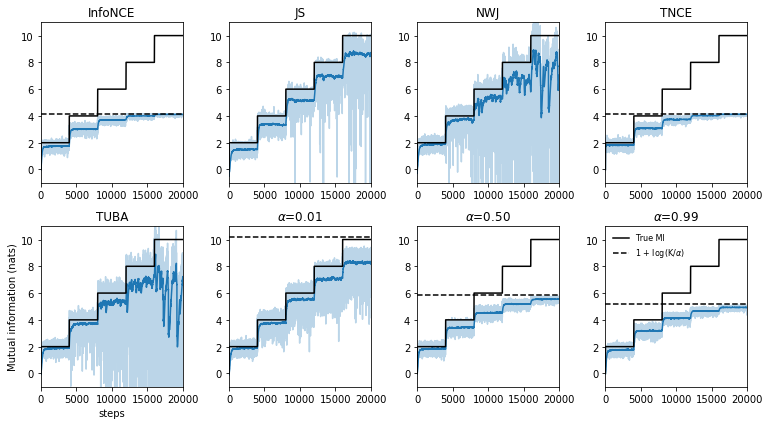

In [17]:
# Smooting span for Exponential Moving Average
EMA_SPAN = 200

# Ground truth MI
mi_true = mi_schedule(train_params['iterations'])

# Names specifies the key and ordering for plotting estimators
names = np.sort(list(estimators.keys()))
lnames = list(map(lambda s: s.replace('alpha', '$\\alpha$'), names))

nrows = min(2, len(estimates))
ncols = int(np.ceil(len(estimates) / float(nrows)))
fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows)) 
if len(estimates) == 1:
    axs = [axs]
axs = np.ravel(axs)
  
for i, name in enumerate(names):
    plt.sca(axs[i])
    plt.title(lnames[i])
    # Plot estimated MI and smoothed MI
    mis = estimates[name]  
    mis_smooth = pd.Series(mis).ewm(span=EMA_SPAN).mean()
    p1 = plt.plot(mis, alpha=0.3)[0]
    plt.plot(mis_smooth, c=p1.get_color())
    # Plot true MI and line for log(batch size)
    plt.plot(mi_true, color='k', label='True MI')
    estimator = estimators[name]['estimator']
    if 'interpolated' in estimator or 'nce' in estimator:
        # Add theoretical upper bound lines
        if 'interpolated' in estimator:
            log_alpha = -np.log( 1+ tf.exp(-estimators[name]['alpha_logit']))
        else:
            log_alpha = 1.
    plt.axhline(1 + np.log(data_params['batch_size']) - log_alpha, c='k', linestyle='--', label=r'1 + log(K/$\alpha$)' )
    plt.ylim(-1, mi_true.max()+1)
    plt.xlim(0, train_params['iterations'])
    if i == len(estimates) - ncols:
        plt.xlabel('steps')
        plt.ylabel('Mutual information (nats)')
plt.legend(loc='best', fontsize=8, framealpha=0.0)
plt.tight_layout();

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())